In [8]:
import xarray as xr
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import cmocean
import glob
import os
import pandas as pd
from scipy.stats import pearsonr

# LOAD DATA

obs_ssdflux_path="/Volumes/Thalassa/ERA5_data/SSDflux_rg/"
obs_curl_path="/Volumes/Thalassa/ORAS5/ORAS5_wind_stress_curl_rg/"
obs_wsm_path="/Volumes/Thalassa/ORAS5/ORAS5_wind_stress_magnitude_rg/"
obs_shdr_path="/Volumes/Thalassa/CORA_SHDR_rg/"

obs_shdr=xr.open_mfdataset(sorted(glob.glob(obs_shdr_path+'*.nc')))
obs_curl=xr.open_mfdataset(sorted(glob.glob(obs_curl_path+'*.nc')))
obs_wsm=xr.open_mfdataset(sorted(glob.glob(obs_wsm_path+'*.nc')))
obs_ssdflux=xr.open_dataset(obs_ssdflux_path+'SSDflux_ERA5_ORAS5.nc')


# --- Compute Climatology (Monthly Means) ---
obs_shdr_clim = obs_shdr.groupby('time.month').mean(dim='time')
obs_curl_clim = obs_curl.groupby('time_counter.month').mean(dim='time_counter')
obs_ssdflux_clim = obs_ssdflux.groupby('time.month').mean(dim='time')
obs_wsm_clim = obs_wsm.groupby('time_counter.month').mean(dim='time_counter')

cmip6_shdr_ens_all=xr.open_dataset("/Volumes/Thalassa/cmip6_clim_ens/shdr.nc")
cmip6_curl_ens_all=xr.open_dataset("/Volumes/Thalassa/cmip6_clim_ens/curl.nc")
cmip6_ssdflux_ens_all=xr.open_dataset("/Volumes/Thalassa/cmip6_clim_ens/ssdflux.nc")
cmip6_wsm_ens_all=xr.open_dataset("/Volumes/Thalassa/cmip6_clim_ens/wsm.nc")

In [9]:
season=[1,2,3,4,5,6,7,8,9,10,11,12]
diff_wsm=cmip6_wsm_ens_all.wsm.sel(month=season).mean('month')-obs_wsm_clim.wsm.sel(month=season).mean('month')
#diff.plot(vmin=-0.04,vmax=0.04)
diff_curl=cmip6_curl_ens_all.curl.sel(month=season).mean('month')-obs_curl_clim.curl.sel(month=season).mean('month')
#diff.plot(vmin=-0.1e-8,vmax=0.1e-8)
diff_Fs=cmip6_ssdflux_ens_all.Fs.sel(month=season).mean('month')-obs_ssdflux_clim.Fs.sel(month=season).mean('month')
#diff.plot(vmin=-0.01e-5,vmax=0.01e-5)
diff_Ft=(cmip6_ssdflux_ens_all.Ft.sel(month=season).mean('month')-obs_ssdflux_clim.Ft.sel(month=season).mean('month'))

#diff=cmip6_ssdflux_ens_all.Frho.median('model').mean('month')-obs_ssdflux_clim.Frho.mean('month')
#diff.plot(vmin=-0.1e-5,vmax=0.1e-5)
diff_b3=cmip6_shdr_ens_all.sel(param='b3').shdr.sel(month=season).mean('month')-obs_shdr_clim.sel(param='b3').shdr.sel(month=season).mean('month')
#diff.plot(vmin=-1e-3,vmax=1e-3)
diff_D1=cmip6_shdr_ens_all.sel(param='D1').shdr.sel(month=season).mean('month')-obs_shdr_clim.sel(param='D1').shdr.sel(month=season).mean('month')
#diff.plot(vmin=-50,vmax=50)
diff_a1=cmip6_shdr_ens_all.sel(param='a1').shdr.sel(month=season).mean('month')-obs_shdr_clim.sel(param='a1').shdr.sel(month=season).mean('month')
diff_a3=cmip6_shdr_ens_all.sel(param='a3').shdr.sel(month=season).mean('month')-obs_shdr_clim.sel(param='a3').shdr.sel(month=season).mean('month')



In [11]:
import numpy as np
import xarray as xr
from scipy.stats import pearsonr


# Function to clean outliers based on IQR
def clean_outliers(data):
    q1 = np.percentile(data, 25, axis=0)
    q3 = np.percentile(data, 75, axis=0)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_mask = (data >= lower_bound) & (data <= upper_bound)
    return data * outlier_mask

# Clean outliers
clean_b3 = clean_outliers(diff_b3)
clean_Fs = clean_outliers(diff_Fs)

# Calculate the Pearson correlation coefficient
def calculate_pearsonr(b3, Fs):
    valid = ~np.isnan(b3) & ~np.isnan(Fs)
    if valid.sum() < 2:  # Need at least two data points to calculate correlation
        return np.nan
    r_value, _ = pearsonr(b3[valid], Fs[valid])
    return r_value

# Apply the correlation function to each lat/lon point
r_values = xr.apply_ufunc(
    calculate_pearsonr,
    clean_b3,
    clean_Fs,
    input_core_dims=[["model"], ["model"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
)

print(r_values)

<xarray.DataArray (lat: 180, lon: 360)> Size: 518kB
dask.array<transpose, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
    param    <U2 8B 'b3'
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    number   int64 8B 0


/var/folders/1w/tylnjhqj10s0yzmzt5ykpls80000gn/T/ipykernel_2129/1219733817.py:25: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r_value, _ = pearsonr(b3[valid], Fs[valid])


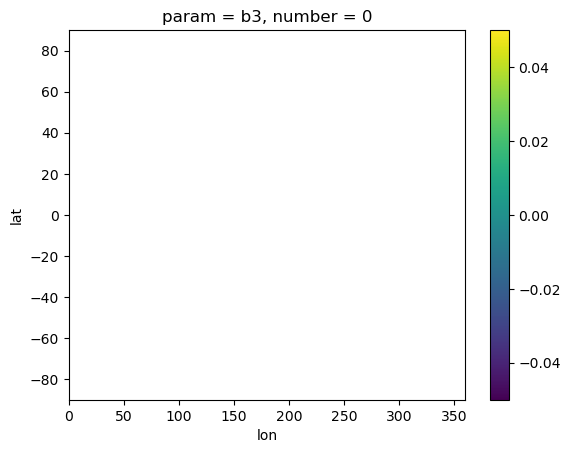

In [12]:
r_values.plot()

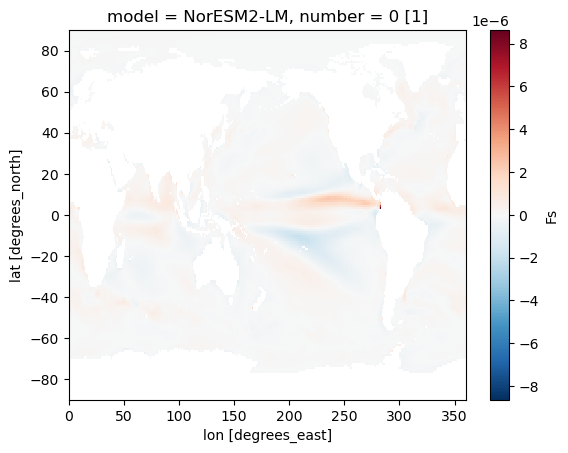

In [24]:
diff_Fs.isel(model=1).plot()